In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import seaborn as sns
from tqdm import tqdm
from Operators import pdeOperator , OperatorConfig
from Operators import BoundaryCondition, BoundaryLoss, BoundaryType, BoundaryLocation
from Models import PINN_Net
from Training import Trainer

In [24]:
# Initialize PDE operator
d = pdeOperator()

# Define domain coordinates
coords = [torch.linspace(-1, 1, 20, requires_grad=True)]

# Define PDE components
operator = lambda u, x: d.laplacian(u, x)  # Laplacian operator
f = lambda x: (-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 
               50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))  # Source term
u_exact = lambda x: 0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x)  # Exact solution

In [33]:
# Initialize neural network model
model = PINN_Net(1, 1, 50, 2)

# Configure PDE operator settings
pde_configurations = OperatorConfig(
    operator=operator,
    weight=torch.tensor(1.0),
    source_function=f,
    u_exact=u_exact,
)

# Define boundary conditions
locations = [BoundaryLocation.X_MAX, BoundaryLocation.X_MIN]
values = [torch.tensor(1.0), torch.tensor(-1.0)]

boundary_conditions = [
    BoundaryCondition(
        type=BoundaryType.DIRICHLET,
        location=location,    
        value=value,
        weight=torch.tensor(1.0),
    ) for value, location in zip(values, locations)
]

# Initialize and run trainer
trainer = Trainer(
    coords, 
    boundary_conditions, 
    pde_configurations, 
    model=model, 
    lr=0.01
)

mse, loss = trainer.train(epochs=1000, rate=500)

Training the model...


Training: 100%|██████████| 1000/1000 [00:05<00:00, 183.52epoch/s, Loss=7.4352e-12, MSE=1.8427e-05]


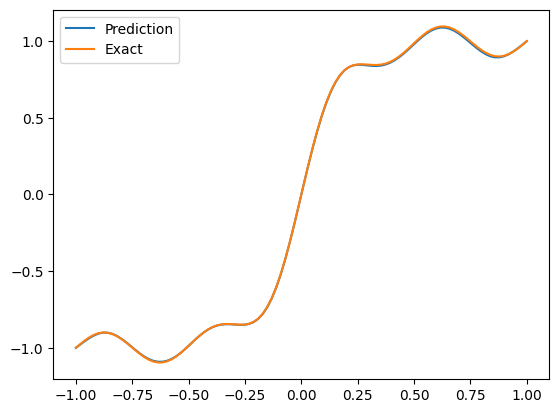

In [34]:
u_pred = trainer.model

x_test = torch.linspace(-1, 1, 100)

prediction = u_pred(x_test.unsqueeze(1))
exact = u_exact(x_test)

plt.plot(x_test, prediction.detach(), label='Prediction')
plt.plot(x_test, exact.detach(), label='Exact')
plt.legend()
plt.show()



In [ ]:
from Models.NO_models import FNO_model #, CNN_model, UNO_model, TFNO_model
#from Models.PINO import PINO_darcy, PINO_poisson
from neuraloperator.neuralop.data.datasets import load_darcy_flow_small, DarcyDataset



train_loader, test_loaders, _ = load_darcy_flow_small(
            n_train=500, batch_size=32,
            test_resolutions=[16, 32], n_tests=[100, 50],
            test_batch_sizes=[32, 32],
        )

parameters = {
    'epochs': 100,
    'lr': 0.01,
    'modes' : 16,
    'in_channels': 1,
    'out_channels': 1,
    'hidden_channels': 16,
    'projection_channel_ratio': 2,
    'optimizer': 'adam',
    'scheduler': False,
    'save_version': 0
}
model = FNO_model(param = parameters)
model.fit(train_loader, test_loaders)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 
Epoch 0: Train Loss = 8.2928e-02, Val Loss = 6.8287e-02, H1 Loss = 9.6594e+00
Epoch 10: Train Loss = 6.9060e-03, Val Loss = 2.5129e-02, H1 Loss = 3.4898e+00
Epoch 20: Train Loss = 4.5871e-03, Val Loss = 1.5520e-02, H1 Loss = 2.2851e+00
Epoch 30: Train Loss = 7.1099e-03, Val Loss = 2.8746e-02, H1 Loss = 3.7292e+00
Epoch 40: Train Loss = 3.5259e-03, Val Loss = 1.8617e-02, H1 Loss = 2.4193e+00
Epoch 50: Train Loss = 4.5330e-03, Val Loss = 2.9418e-02, H1 Loss = 3.5472e+00
Epoch 60: Train Loss = 3.2195e-03, Val Loss = 2.3118e-02, H1 Loss = 2.5356e+00
Epoch 70: Train Loss = 2.1065e-03, Val Loss = 2.2038e-02, H1 Loss = 2.2554e+00
Epoch 80: Train Loss = 1.6639e-03, Val Loss = 1.8071e-02, H1 Loss = 1.7881e+00
Epoch 90: Train Loss = 3.5440e-03, Val Loss = 3.1464e-02, H1 Loss = 2.4969e+00


(0.00190705989007256, 0.017044740030542016)

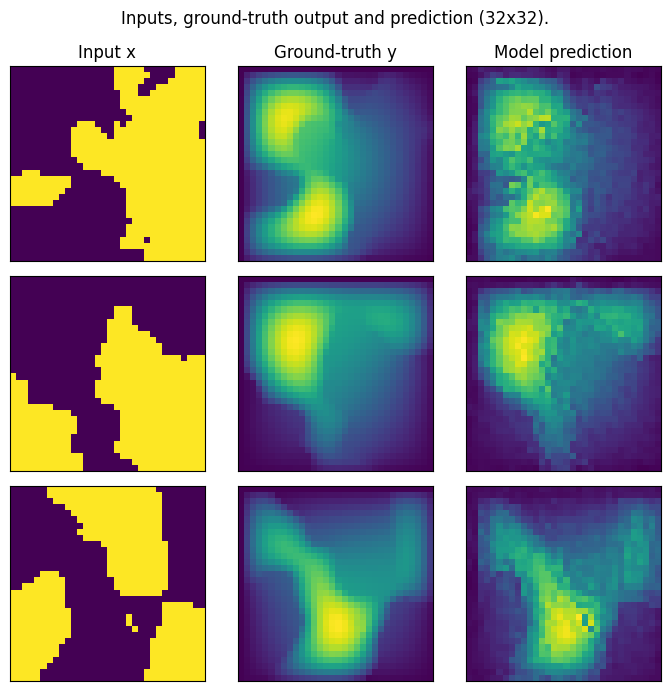

In [21]:
import matplotlib.pyplot as plt

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model.predict(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].detach().numpy())
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])


    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()